In [ ]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### Classification - Based on Week 3

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In week 3, you:
- Explored the dataset
- Built a full data pipeline
- Pre-processed data, explored features

Building on your work of week 3:
- Split dataset into 3 sets:
  - 70% -> Training and cross validation
  - 15% -> Model Stacking
  - 15% -> Testing
  

- Tune a decision tree classfier:
  - select a score (http://scikit-learn.org/stable/modules/model_evaluation.html). Explain your choice 
  - tune one parameter a time. Generate a plot for the score vs parameter values. Analyze your results.
    - criterion, max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes=None    
  - tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.
  

For this assignment, we choose the ROC-AUC as a score measure because:

 - AUC applies to binary classifiers
 - We want to choose hyperparameters with the highest AUC score so that we have a greater True Positives and a lower number of False Positives. Note: higher AUC score does not necessary lead to a higher accuracy score as can be seen in a case of a such hyperparameter as min_samples_split; therefore, we would need to sacrifice some AUC score for the accuracy score.
 

In [ ]:
import os
from six.moves import urllib

"""
Data Set Information:

This research aimed at the case of customersâ€™ default payments in Taiwan and compares the predictive accuracy of 
probability of default among six data mining methods. From the perspective of risk management, the result of 
predictive accuracy of the estimated probability of default will be more valuable than the binary result of 
classification - credible or not credible clients. Because the real probability of default is unknown, this study 
presented the novel â€œSorting Smoothing Methodâ€ to estimate the real probability of default. With the real 
probability of default as the response variable (Y), and the predictive probability of default as the independent 
variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by 
artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to 
zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural 
network is the only one that can accurately estimate the real probability of default.


Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
This study reviewed the literature and used the following 23 variables as explanatory variables: 
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her 
family (supplementary) credit. 
X2: Gender (1 = male; 2 = female). 
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
X4: Marital status (1 = married; 2 = single; 3 = others). 
X5: Age (year). 
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 
"""

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/"
CREDIT_PATH = os.path.join("datasets", "credit-default")
CREDIT_URL = DOWNLOAD_ROOT + "default%20of%20credit%20card%20clients.xls"

#CREDIT_URL

def fetch_creditdefault_data(credit_url=CREDIT_URL, credit_path=CREDIT_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    file_path = os.path.join(credit_path, "default of credit card clients.xls")
    
    urllib.request.urlretrieve(credit_url, file_path) 
    # The commented code above wont execute in proxy settings. Please download the files from Github
    # https://github.com github.com/RoyMachineLearning/3253-Machine-Learning
    
#fetch_creditdefault_data()

import pandas as pd

def load_CRDEFAULT_data(credit_path=CREDIT_PATH):
    file_path = os.path.join(credit_path, "default of credit card clients.xls")
    return pd.read_excel(file_path, sheet = 0, skiprows= 1, header = 0)

df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", skiprows= 1, header = 0)
df = df.drop('ID',axis=1)

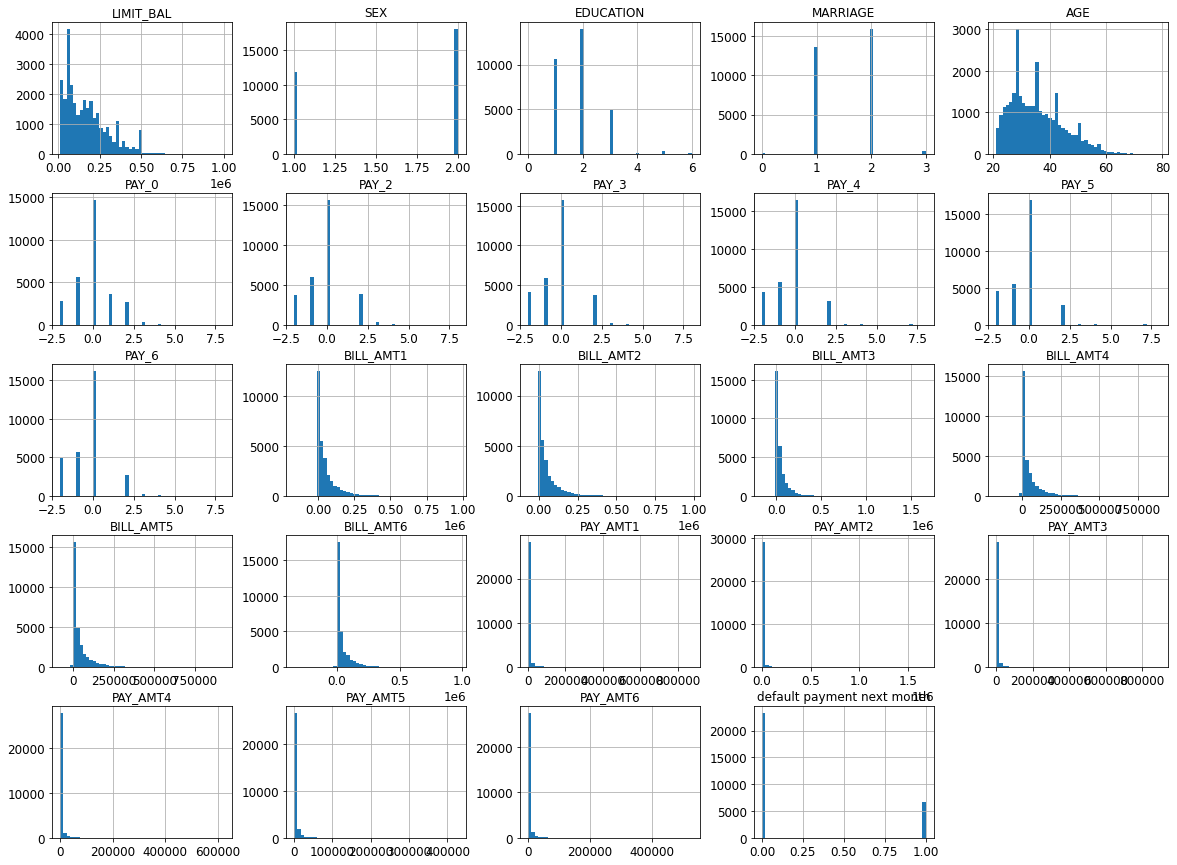

In [ ]:
#Part 1 - Explore the data

import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
TARGET = "default payment next month"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

TARGET: default payment next month
columns_predictors: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
columns_categorical: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
columns_numerical: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [ ]:
X = df[columns_predictors]
y = df[TARGET]

from sklearn.model_selection import train_test_split
## Enter your Code here
## Enter your Code here

In [ ]:
#Create numerical pipeline to transform numerical values

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder ,StandardScaler

#Convert the non transformed Dataframe into list.
columns_categorical_list = list(columns_categorical)
columns_numerical_list = list(columns_numerical)

pipeline_categorical = Pipeline([
  ('onehot', OneHotEncoder()),
])

pipeline_numerical = Pipeline([
  ('scaler', StandardScaler()),
])

pipeline_full = ColumnTransformer([
  ("categorical", pipeline_categorical, columns_categorical_list),
  ("numerical", pipeline_numerical, columns_numerical_list),
])

In [ ]:
pipeline_full.fit(X_train)
## Enter your Code here
## Enter your Code here

In [ ]:
#define the Plots for Checking the roc_auc values vs Parameter

def plot_Parameters_Vs_Scores(criterion_estimators,roc_auc_values,plotType):
    if plotType == "Scatter":
        plt.scatter(criterion_estimators, roc_auc_values)
    if plotType == "Line":
        plt.plot(criterion_estimators, roc_auc_values) 
    plt.xlabel("Parameters Vs AUC Scores")
    plt.legend(loc="best")
    plt.grid(True)

#Taken from Xuan's reference
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Tune Hyperparameter : Criterion

In [ ]:
#Evaluate the Decision tree model on the training set
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

criterion_estimators_1 = ['gini', 'entropy']
## Enter your Code here
## Enter your Code here

In [ ]:
plot_Parameters_Vs_Scores(criterion_estimators_1, roc_auc_values,"Line")
plt.show()

In [ ]:
#Check the Accuracy on Test data 
## Enter your Code here
## Enter your Code here

Tune Hyperparameter : Max Depth

In [ ]:
# Criterion Parameter - Max Depth

criterion_estimators_2 = [1, 2, 3, 4, 5]

## Enter your Code here
## Enter your Code here

In [ ]:
plot_Parameters_Vs_Scores(criterion_estimators_2, roc_auc_values,"Line")
plt.show()

In [ ]:
#Print the accuracy score
## Enter your Code here
## Enter your Code here

In [ ]:
#Check the Accuracy on Test data 
## Enter your Code here
## Enter your Code here

Tune Hyperparameter : Min Samples Split

In [ ]:
#Criterion = Min Samples Split.
criterion_estimators_3 = list(range(2,10))

## Enter your Code here
## Enter your Code here

In [ ]:
#Print the accuracy score
## Enter your Code here
## Enter your Code here

In [ ]:
#Check the Accuracy on Test data 
## Enter your Code here
## Enter your Code here

Tune Hyperparameter : Min Sample Leaf

In [ ]:
#Criteria : min_samples_leaf
criterion_estimators_4 = [(i + 1) / 10 for i in range(5)]

## Enter your Code here
## Enter your Code here

In [ ]:
#Print the accuracy score
## Enter your Code here
## Enter your Code here

In [ ]:
#Check the Accuracy on Test data 
## Enter your Code here
## Enter your Code here

Tune Hyperparameter : Min Sample Leaf

In [ ]:
#Criterion = max_leaf_nodes
## Enter your Code here
## Enter your Code here

In [ ]:
plot_Parameters_Vs_Scores(criterion_estimators_5, roc_auc_values,"Line")
plt.show()

In [ ]:
#Print the accuracy score
## Enter your Code here
## Enter your Code here

In [ ]:
#Check the Accuracy on Test data 
## Enter your Code here
## Enter your Code here

As the accuracy drops on the test set - this criterion parameter sufficient enough be a good model.

tune all parameters at the same time using a randomgrid(http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). First, run with a coarse grid, then refine in the next iteration. Use the information from the previous step to select parameter values.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [ ]:
#tuning all the parameters together 
parameter_distribution = {'criterion' : criterion_estimators_1, 'max_depth' : criterion_estimators_2,
                          'min_samples_split' : criterion_estimators_3, 'min_samples_leaf' : criterion_estimators_4,
                          'max_leaf_nodes' : criterion_estimators_5}

## Enter your Code here
## Enter your Code here

In [ ]:
#Get the best estimator on Randomized SearchCV
## Enter your Code here
## Enter your Code here

In [ ]:
# Based on the accuracy scores, we select the best estimator and work with the test set
## Enter your Code here
## Enter your Code here

#### Conclusions?

For Q1. Decision Tree performs the best under the hyperparameter , {'criterion': 'gini'} on the training set. But when we compare the model accuracy on the test set. The Accuracy drops considerably - indicating an instance of clear overfitting on the
training set. Thus a higher accuracy is not the only measure. 

Whereas The Hyper parameter "min_samples_leaf" generates a good accuracy over the test set when compared to the training set.
Although the accuracy number is low, but this is a more useful model when compared to other models. 

When we run all the Hyper parameters using randomized search, The model is slightly overfitted. But it is a recommended approach to use with the right number of parameters.

### Ensemble Learning

Make sure to read and understand the documentation for each classifier.

  
- Tune the following classifiers:
  - Random forest classfier
  - Adaboost Tree classifier
  - Extra trees classifier
  - Gradient Boosted Tree classifier
  - Logistic Regression
  
- Analyze, compare, and interpret your results
- What ensemble yields the best result? Can you identify certain types of events that are classified better/worse from the type of algorithm?
- Is the feature importance consistent for all classifiers?

In [ ]:
#import the libraries for all the classifiers.

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
#Design the random forest classifier

# Random Forest Classifier

n_estimators = [10, 200]
max_features = [0.1, 0.5]
max_depth = [2, 10, 20] 
oob_score = [True, False]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5]
max_leaf_nodes = [2, 10, 100]

parameter_random_forest = {'n_estimators' : n_estimators, 'max_features' : max_features,
                     'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                    'oob_score' : oob_score, 'min_samples_leaf': min_samples_leaf, 
                     'max_leaf_nodes' : max_leaf_nodes}
             
Random_Forest_Classifier = RandomForestClassifier(random_state = 42)

#use grid search to tune the model

## Enter your Code here
## Enter your Code here)

In [ ]:
#Now Predict on the Stack Dataset
## Enter your Code here
## Enter your Code here

In [ ]:
# Test on the Test Data
## Enter your Code here
## Enter your Code here

To identify certain types of events that are classified better/worse from this classifier - we use the confusion matrix

In [ ]:
#Create the confusion Matrix on the stack set for Random Forest Classifier
## Enter your Code here
## Enter your Code here

In [ ]:
#Create the confusion Matrix on the test set for Random Forest Classifier
## Enter your Code here
## Enter your Code here

Now we capture the feature importance for the random forest classifer - sorted in ascending order

In [ ]:
for name, score in sorted(zip(X_stack.columns, Random_Forest_estimators.feature_importances_), key=lambda x: x[1],reverse=True):
    print(name, score)

In [ ]:
# Now Build the ADA Boost Classifier

n_estimators = [5, 10, 15, 20]
learning_rate = [0.05, 0.01]
algorithm = ['SAMME', 'SAMME.R']

Ada_Classifer = AdaBoostClassifier(random_state = 42)
## Enter your Code here
## Enter your Code here

In [ ]:
#check accuracy on stack dataset
## Enter your Code here
## Enter your Code here

In [ ]:
# Check the accuracy on the Test Data
## Enter your Code here
## Enter your Code here

Now we identify certain types of events that are classified better/worse from ADA classifier - we use the confusion matrix

In [ ]:
#Create the confusion Matrix on the stack set for ADA Classifier
## Enter your Code here
## Enter your Code here

In [ ]:
#Create the confusion Matrix on the test set for ADA Classifier
## Enter your Code here
## Enter your Code here

Now we capture the feature importance for the Ada Classifer - Sorted in ascending order

In [ ]:
for name, score in sorted(zip(X_stack.columns, AdaClassifier_Estimators.feature_importances_), key=lambda x: x[1],reverse=True):
    print(name, score)

In [ ]:
# The next we build is an Extra Trees Classifier

Extra_Classifier = ExtraTreesClassifier(random_state = 42)

n_estimators = [3, 70, 100, 200]
max_features = [0.1,0.3,0.5]
max_depth = [2, 50, 70]
min_samples_split = [0.1, 0.5]
min_samples_leaf = [0.1, 0.5] # Mhm, this one leads to accuracy of test and train sets being the same.

parameter_Extra_Classifier = {'n_estimators' : n_estimators, 'max_features' : max_features,
                         'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                         'min_samples_leaf' : min_samples_leaf}

## Enter your Code here
## Enter your Code here

In [ ]:
#check accuracy on stack data
## Enter your Code here
## Enter your Code here

In [ ]:
# check the accuracy on the Test Data
## Enter your Code here
## Enter your Code here

Now we identify certain types of events that are classified better/worse from Extra Trees classifier - we use the confusion matrix

In [ ]:
#Create the confusion Matrix on the stack set for Extra Classifier
## Enter your Code here
## Enter your Code here

In [ ]:
#Create the confusion Matrix on the test set for Extra Classifier
## Enter your Code here
## Enter your Code here

Now we capture the feature importance for the Extra Trees Classifer, sorted in ascending order.

In [ ]:
for name, score in sorted(zip(X_stack.columns, ExtraClassifier_Estimators.feature_importances_), key=lambda x: x[1],reverse=True):
    print(name, score)

In [ ]:
# Gradient Boosting Classifier

GB_Classifier = GradientBoostingClassifier(random_state = 42)

n_estimators = [3, 7]
learning_rate = [0.1, 0.01, .001]
max_depth = [3, 15, 20]
min_samples_split = [0.2, 0.3]
min_samples_leaf = [3, 4]
max_features = [4, 6]
max_leaf_nodes = [2, 3]
                            
parameter_GB_Classifier = {'n_estimators' : n_estimators, 'learning_rate' : learning_rate,
                              'max_depth' : max_depth, 'min_samples_split' : min_samples_split,
                              'min_samples_leaf' : min_samples_leaf, 'max_features' : max_features,
                              'max_leaf_nodes' : max_leaf_nodes}

## Enter your Code here
## Enter your Code here

In [ ]:
#Now Predict on the Stack Dataset
## Enter your Code here
## Enter your Code here

In [ ]:
# check the accuracy on the Test Data
## Enter your Code here
## Enter your Code here

Now we identify certain types of events that are classified better/worse from Gradient Boosting classifier - we use the confusion matrix

In [ ]:
#Create the confusion Matrix on the stack set for GB Classifier
## Enter your Code here
## Enter your Code here

In [ ]:
#Create the confusion Matrix on the test set for GB Classifier
## Enter your Code here
## Enter your Code here

In [ ]:
for name, score in sorted(zip(X_stack.columns, GB_estimators.feature_importances_), key=lambda x: x[1],reverse=True):
    print(name, score)

#### Conclusions?

Q. (Optional) If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?

Q. (Optional) If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?

Q. (Optional) What is the difference between hard and soft voting classifiers?

Q. (Optional) If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?

Q. (Optional) If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?